In [1]:

%load_ext autoreload
%autoreload 2



from jax import config
config.update("jax_enable_x64", True)
import jax
import json
from jax.tree_util import Partial

import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
key = jr.PRNGKey(123)

import scipy.optimize as spo
from dataclasses import dataclass
from gpjax.base import param_field, static_field
import math
from gpjax.kernels.base import AbstractKernel
from gpjax.kernels import RBF
import optax as ox
from gpjax.kernels.stationary.utils import squared_distance
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd
from gpjax.typing import (
    Array,
    ScalarFloat,
)
from jaxtyping import (
    Float,
    Num,
)

# 100_000 entries sampled across time/lat/lon over first day of data

## X2D has:

0"Sea surface temperature (K)"

1"Sensible heat flux (W/m^2)"

2"Latent heat flux (W/m^2)"

3"Vertically-integrated moisture convergence (kg/m^2)"

4"Column relative humidity (%)"


## X3D has:

0"Absolute temperature (K)"

1"Relative humidity (%)"

2"Specific humidity (kg/kg)"

3"Geopotential height (m^2 s^-2)"

4"Zonal wind (m/s)"

5"Meridional wind (m/s)"

6"Potential temperature (K)"

7"Equivalent potential temperature (K)"

8"Equivalent potential temperature saturation deficit (K)"

9"Saturated equivalent potential temperature (K)"

10"MSE-conserving plume buoyancy (m/s^2)"


## static has:

0"Land-sea mask"

1"Angle of sub-gridscale orography (rad)Anisotropy of sub-gridscale orography"

2"Standard deviation of sub-gridscale orography"

3"Slope of sub-gridscale orography"

## Y has:

0"ERA5 Precipitation (mm/hr)"

1"TRMM Precipitation (mm/hr)"

2"TRMM Relative Error (%)"

# plev are
1000.,   2000.,   3000.,   5000.,   7000.,  10000., 15000.,
20000.,  25000.,  30000.,  40000.,  50000.,  60000.,  70000.,80000.,  85000.,  90000.,  92500.,  95000.,  97500., 100000.


In [2]:
# load data
X2d = jnp.array(jnp.load("..//data/100_000_one_day/X2D_sample.npy"), dtype=jnp.float64) # [N, D]
X3d = jnp.array(jnp.load("../data/100_000_one_day/X3D_sample.npy"), dtype=jnp.float64) # [N, D]
Xstatic = jnp.array(jnp.load("../data/100_000_one_day/XSTATIC_sample.npy"), dtype=jnp.float64) # [N, D]
Y = jnp.array(jnp.load("../data/100_000_one_day/Y_sample.npy"), dtype=jnp.float64) # [N, 1]
pressure = jnp.array([[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,60000,70000,80000, 85000,90000,92500,95000,97500,100000]], dtype=jnp.float64)


# look at ERA5 rain
Y = Y[:,0:1]  

# remove any entries with nan
X3d_nan_idx = jnp.isnan(X3d).any(axis=1).any(axis=1)
X2d_nan_idx = jnp.isnan(X2d).any(axis=1)
Xstatic_nan_idx = jnp.isnan(Xstatic).any(axis=1)
Y_nan_idx = jnp.isnan(Y).any(axis=1)
any_nan = X3d_nan_idx | X2d_nan_idx | Y_nan_idx | Xstatic_nan_idx
no_nan = ~ any_nan
print(f"Removed {any_nan.sum()} entries with nan")
X2d = X2d[no_nan,:]
X3d = X3d[no_nan,:,:]
Xstatic = Xstatic[no_nan,:]
Y = Y[no_nan,:]


# just keep the "prognostic" inputs that joe considered (for now)
# RH, tehta_e^+, theta_e, theta_e^*
names_3d =  ["RH", "tehta_e^+", "theta_e", "theta_e^*"]
idx_3d = [1, 9, 7, 8 ]
X3d = X3d[:,idx_3d,:]


# also include his "normalised" sigma_o
sigma_o = jnp.where(Xstatic[:,0]<0.5, 0.0, 1.0+jnp.log(1+Xstatic[:,2]))
X2d = sigma_o[:,None]


#remove all pressure levels below 500 hPA
lowest_idx = 7
print(f"Removed all pressure levels below {pressure[:,lowest_idx]} hPa")

X3d = X3d[:, :, lowest_idx:]
pressure_levels = pressure[:,lowest_idx:]

# remove no rain days
print(f"Removed {(Y[:,0]>0).sum()} entries with zero rain")
X3d = X3d[Y[:,0]>0,:]
X2d = X2d[Y[:,0]>0,:]
Y = Y[Y[:,0]>0,:]
# also log Y
print(f"Applied log transform to Y")
Y = jnp.log(Y)
print(f"then standardized Y")
Y_mean = jnp.mean(Y)
Y_std = jnp.std(Y)
Y = (Y - Y_mean) / Y_std

# standardize inputs
X3d_std = jnp.std(X3d, axis=0)
X3d_mean = jnp.mean(X3d,axis=0)
X3d = (X3d - X3d_mean) / X3d_std
X2d_std = jnp.std(X2d, axis=0)
X2d_mean = jnp.mean(X2d,axis=0)
X2d = (X2d - X2d_mean) / X2d_std


# look at tiny data for now
N_train = 10_000
print(f"Only using {N_train} training points!")
X3d_train, X2d_train, Y_train = X3d[:N_train,:],X2d[:N_train,:], Y[:N_train,:]
num_2d_variables= X2d_train.shape[-1]
X_train = jnp.hstack((X3d_train.reshape(len(X3d_train), -1), X2d_train))



Removed 24779 entries with nan
Removed all pressure levels below [20000.] hPa
Removed 56920 entries with zero rain
Applied log transform to Y
then standardized Y
Only using 10000 training points!


In [3]:
@dataclass
class VerticallyIntegratedKernel(AbstractKernel):
    base_kernel: AbstractKernel = gpx.kernels.RBF()
    smoother_mean: Float[Array, " D"]  = param_field(None)
    smoother_input_scale: Float[Array, " D"] = param_field(None, bijector=tfb.Softplus(low=jnp.array(1.0e-5, dtype=jnp.float64)))
    #smoother_bias: Float[Array, " D"] = param_field(None, bijector=tfb.Softplus(low=jnp.array(1.0e-5, dtype=jnp.float64)))
    #smoother_output_scale: Float[Array, " D"] = param_field(None, bijector=tfb.Softplus(low=jnp.array(1.0e-5, dtype=jnp.float64)))
    Z_levels: Float[Array, " D"] = static_field(pressure_levels)
   
    def __post_init__(self):
        self.Z_mean = jnp.mean(self.Z_levels)
        self.Z_std = jnp.std(self.Z_levels)
        self.Z_levels = (self.Z_levels - self.Z_mean) / self.Z_std

    def __call__(self, x, y):
        x, y = self.slice_input(x), self.slice_input(y)
        smoothed_x, smoothed_y = self._smooth(x), self._smooth(y)
        return self.base_kernel(smoothed_x, smoothed_y )
    
    def _smooth(self, x): # [d*z] -> [d]
        x_to_smooth = x.reshape(-1,self.Z_levels.shape[1]) # [d, z]
        smoothing_weights = jnp.exp(-0.5*((self.Z_levels-self.smoother_mean.T)/(self.smoother_input_scale.T))**2) # [d, z]
        smoothing_weights = (smoothing_weights/ jnp.sum(smoothing_weights, axis=-1, keepdims=True)) # [d, z]
        return jnp.sum(jnp.multiply(smoothing_weights ,x_to_smooth), axis=-1) # [d]
    


def prep_kernel(D: gpx.Dataset, num_2d_variables:int, bij_lengthscale:bool = True):
    lengthscale_bij = tfb.SoftClip(jnp.array(1e-2, dtype=jnp.float64),jnp.array(1e2, dtype=jnp.float64))
    base_kernel = RBF(lengthscale=jnp.array([1.0]*4), variance = jnp.var(D.y))
    if bij_lengthscale:
        base_kernel = base_kernel.replace_bijector( lengthscale = lengthscale_bij)
    kernel_3d = VerticallyIntegratedKernel(
        base_kernel = base_kernel, 
        smoother_mean = jnp.array([[0.0]*4]),
        smoother_input_scale = jnp.array([[1.0]*4]),
        active_dims=jnp.arange(X_train.shape[-1])[:-num_2d_variables]
        )
    kernel_2d = RBF(lengthscale=jnp.array([0.1]*num_2d_variables), active_dims=jnp.arange(X_train.shape[-1])[-num_2d_variables:])
    kernel_2d = kernel_2d.replace_trainable( variance = False)
    if bij_lengthscale:
        kernel_2d = kernel_2d.replace_bijector( lengthscale = lengthscale_bij)
    return kernel_3d * kernel_2d

In [4]:
def plot_params(model, title=None):
    if isinstance(model, gpx.variational_families.AbstractVariationalFamily):
        model = model.posterior
    plt.figure()
    opt_3d_kernel =model.prior.kernel.kernels[0]
    lengthscales = opt_3d_kernel.base_kernel.lengthscale
    #smoothing_weights = opt_3d_kernel.smoother_bias.T + (1 / (jnp.sqrt(2*math.pi)*opt_3d_kernel.smoother_input_scale.T))*jnp.exp(-0.5*(opt_3d_kernel.Z_levels-opt_3d_kernel.smoother_mean.T)**2/(opt_3d_kernel.smoother_input_scale).T) # [4, 21]
    #smoothing_weights = (jnp.exp(-0.5*((opt_3d_kernel.Z_levels-opt_3d_kernel.smoother_mean.T)/(opt_3d_kernel.smoother_input_scale.T))**2)) # [4, 21]
    smoothing_weights =  jnp.exp(-0.5*((opt_3d_kernel.Z_levels-opt_3d_kernel.smoother_mean.T)/(opt_3d_kernel.smoother_input_scale.T))**2) # [4, 21]
    smoothing_weights = (smoothing_weights/ jnp.sum(smoothing_weights, axis=-1, keepdims=True)) # [4, 21]
    for i in range(len(names_3d )):
        plt.plot(smoothing_weights[i,:].T,pressure_levels[0,:], label=f"{names_3d[i]} with lengthscales {lengthscales[i]:.2f}")
    plt.legend()
    plt.title(title+f"other lengthscales are {model.prior.kernel.kernels[1].lengthscale}")
    plt.gca().invert_yaxis()


In [5]:
@dataclass
class Gamma(gpx.likelihoods.AbstractLikelihood):
    v: Float[Array, "#N"] = param_field(
        jnp.array(10.0), bijector=tfb.Softplus()
    )
    def link_function(self, f):
        #https://www2.imm.dtu.dk/pubdb/edoc/imm6637.pdf
        #C = jax.scipy.stats.norm.cdf(f)
        C = jnp.exp(f)
        return tfd.Gamma(self.v, C, allow_nan_stats=False)

    def predict(self, dist: tfd.Distribution) -> tfd.Distribution:
        raise NotImplementedError
    
@dataclass
class Exponential(gpx.likelihoods.AbstractLikelihood):
    def link_function(self, f):
        C = jnp.exp(f)
        return tfd.Exponential(1/C)

    def predict(self, dist: tfd.Distribution) -> tfd.Distribution:
        raise NotImplementedError






  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Expected dict, got VariationalGaussian(posterior=ConjugatePosterior(prior=Prior(kernel=CombinationKernel(compute_engine=DenseKernelComputation(), active_dims=None, name='AbstractKernel', kernels=[VerticallyIntegratedKernel(compute_engine=DenseKernelComputation(), active_dims=Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55], dtype=int64), name='AbstractKernel', base_kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.19303507e-03, 2.47724580e+00, 2.73489896e+00, 5.76212142e+00],      dtype=float64), variance=Array(1.20385692, dtype=float64)), smoother_mean=Array([[ 0.34036342,  3.03686828, -0.21452565,  0.76032669]], dtype=float64), smoother_input_scale=Array([[ 0.42537074,  1.1143254 , -3.06310826,  0.82225378]], dtype=float64), Z_levels=Array([[-1.67728313, -1.4980315 , -1.31877986, -0.9602766 , -0.60177334,
        -0.24327007,  0.11523319,  0.47373646,  0.65298809,  0.83223972,
         0.92186554,  1.01149135,  1.10111717,  1.19074298]],      dtype=float64)), RBF(compute_engine=DenseKernelComputation(), active_dims=Array([56], dtype=int64), name='RBF', lengthscale=Array([-2.35260813], dtype=float64), variance=Array(0.54132485, dtype=float64))], operator=<function prod at 0x7f1a61b28f70>), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=10000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(-0.16517849, dtype=float64)), jitter=1e-06), inducing_inputs=Array([[ 1.02293462,  1.76815776,  0.98413708, ..., -0.7472448 ,
        -0.37563045, -0.04849711],
       [-1.05840385, -1.19289751, -0.66907987, ...,  1.86934734,
         1.34997168, -0.04849711],
       [-0.26893478, -1.06522658, -1.0352061 , ...,  0.42613076,
         0.63446028, -0.04849711],
       ...,
       [ 0.48660277, -0.86020822, -0.28729169, ...,  0.801576  ,
         1.04861435, -0.04849711],
       [ 0.52628739, -0.4978531 ,  0.09334093, ...,  1.18531328,
         1.20183087, -0.04849711],
       [ 1.46028906,  1.71158842,  2.06492851, ..., -0.52074368,
        -0.34735195, -0.04849711]], dtype=float64), jitter=1e-06, variational_mean=Array([[ 1.32811944],
       [-0.16185215],
       [-0.50502991],
       [ 0.68166295],
       [-1.31177197],
       [ 0.589459  ],
       [ 1.19886958],
       [ 0.23702975],
       [-0.58849045],
       [-1.67691273],
       [-0.520738  ],
       [ 0.24525975],
       [-0.34960085],
       [ 0.65615279],
       [-1.11414843],
       [ 0.90932664],
       [ 0.1432127 ],
       [-0.03013504],
       [-0.50846024],
       [-0.43007802],
       [ 0.30395141],
       [ 0.28940571],
       [-1.0862477 ],
       [ 1.0770514 ],
       [ 1.40614859],
       [ 0.4525736 ],
       [ 1.30167559],
       [ 0.63888653],
       [-1.08031629],
       [-1.01742013],
       [ 0.65231769],
       [-0.90522074],
       [ 0.90334513],
       [-0.5838164 ],
       [-0.91776476],
       [-0.58979753],
       [-0.33213624],
       [-0.22478482],
       [-0.43129146],
       [ 0.31598977],
       [-0.25253076],
       [ 0.45164548],
       [ 0.1814136 ],
       [-0.47406644],
       [-0.46391879],
       [-0.36579513],
       [ 1.57860709],
       [-0.64768358],
       [-1.48285942],
       [-0.81861239],
       [ 0.68098472],
       [-0.46347125],
       [ 0.70951494],
       [-0.77397113],
       [ 0.49681569],
       [ 0.56446308],
       [ 0.74057031],
       [ 1.45778078],
       [ 0.11368282],
       [-1.34437767],
       [ 0.10154302],
       [-1.74964318],
       [ 0.32881953],
       [ 1.42522612],
       [-0.92751315],
       [-0.77002227],
       [ 0.88806599],
       [ 0.51436135],
       [-1.90215385],
       [-0.86321794],
       [-0.67165378],
       [-0.58760151],
       [ 0.5910188 ],
       [ 0.69296015],
       [ 0.09717765],
       [ 0.21708846],
       [ 0.35978699],
       [ 0.1323798 ],
       [ 0.46795929],
       [ 0.77942125],
       [-0.44009517],
       [-0.3079299 ],
       [-1.3055052 ],
       [ 0.50549906],
       [-0.49723327],
       [-0.55900012],
       [-0.38798088],
       [-1.00006599],
       [-0.51494384],
       [-0.45119767],
       [ 1.13267271],
       [ 0.13274205],
       [-0.06145229],
       [-0.3036447 ],
       [ 0.09004455],
       [ 0.41636464],
       [ 0.61046571],
       [-0.83322518],
       [-0.9883189 ],
       [ 0.69580333]], dtype=float64), variational_root_covariance=Array([2.24446628e-03, 3.36039903e-05, 1.22473398e-04, ...,
       9.91972917e-04, 5.96902460e-04, 7.35443406e-03], dtype=float64)).

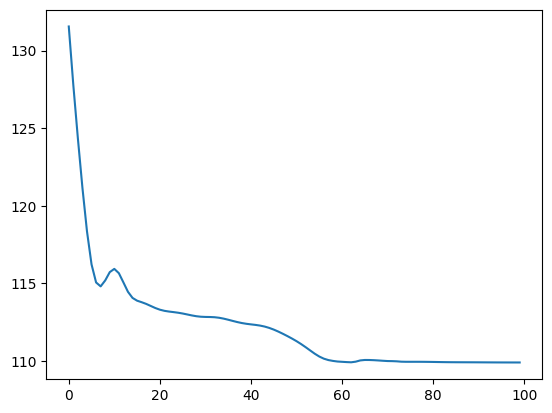

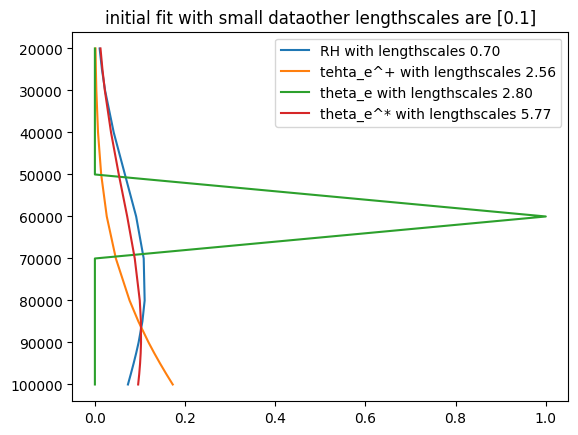

In [6]:
# prep fancy kernel for model
D = gpx.Dataset(X=X_train,y = Y_train)
prior = gpx.gps.Prior(mean_function= gpx.mean_functions.Zero(), kernel = prep_kernel(D, num_2d_variables))
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)


# first fit with small data to get init for SVGP
num_data_for_init=100
D_small = gpx.Dataset(X = D.X[:num_data_for_init,:],y = D.y[:num_data_for_init,:])
posterior = prior * likelihood
objective = jax.jit(gpx.objectives.ConjugateMLL(negative=True))
#objective = jax.jit(gpx.objectives.NonConjugateMLL(negative=True))
opt_posterior, history = gpx.fit(
    model=posterior,
    objective=objective,
    train_data=D_small,
    optim=ox.adam(learning_rate=1e-1),
    num_iters=100,
    key=jr.PRNGKey(42),
)
plt.plot(history)
plot_params(opt_posterior, title="initial fit with small data")



# choose inducing inputs and init SVGP
num_inducing = 100
#z = jr.normal(key, (num_inducing , D.X.shape[-1])) # todo enable this
z = D.X[:num_inducing,:]


init_posterior_at_inducing = opt_posterior.predict(z, D_small)
# todo try whitening ?
q = gpx.variational_families.VariationalGaussian(
    posterior=opt_posterior, 
    inducing_inputs=z,
    variational_mean= init_posterior_at_inducing.mean()[:,None],
    variational_root_covariance= jnp.linalg.cholesky(init_posterior_at_inducing.covariance()), # todo check this is right!
)
q = q.replace_trainable(inducing_inputs=False)
q = q.replace_trainable(variational_mean=False)
q = q.replace_trainable(variational_root_covariance=False)

objective = jax.jit(gpx.objectives.ELBO(negative=True))

optim=ox.adam(1e-1)

opt_q, history = gpx.fit(
    model=q,
    objective=objective,
    train_data=D,
    optim=optim,
    num_iters=100,
    key=jr.PRNGKey(42),
    batch_size=128,
)


plt.figure()
plt.plot(history)
plot_params(opt_q, title="full fit")


In [63]:
def map_nested_fn(fn):
  '''Recursively apply `fn` to the key-value pairs of a nested dict'''
  def map_fn(nested_dict):
    if not isinstance(nested_dict,dict):
      nested_dict = nested_dict.__dict__
    return {k: (map_fn(v) if isinstance(v, dict) else fn(k, v))
            for k, v in nested_dict.items()}
  return map_fn
label_fn = map_nested_fn(lambda k, _: k)


optim = ox.chain(
    ox.multi_transform(
      {
        "posterior": ox.adam(1e-1), 
        "variational_mean": zero_grads(), 
        "variational_root_covariance": zero_grads(),
        "jitter": zero_grads(), 
        "pytree_node": zero_grads(), 
        "trainable": zero_grads(), 
        "inducing_inputs": zero_grads(),
        "bijector": zero_grads(),
        },label_fn), # opt kernel params
    #ox.multi_transform({"posterior": zero_grads(), "variational_mean": ox.adam(1e-1), "variational_root_covariance": ox.adam(1e-1)},label_fn), # opt variational params
    )

optim.init(q)

ValueError: Expected dict, got VariationalGaussian(posterior=ConjugatePosterior(prior=Prior(kernel=CombinationKernel(compute_engine=DenseKernelComputation(), active_dims=None, name='AbstractKernel', kernels=[VerticallyIntegratedKernel(compute_engine=DenseKernelComputation(), active_dims=Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55], dtype=int64), name='AbstractKernel', base_kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([0.69925132, 2.55865816, 2.79839271, 5.76529243], dtype=float64), variance=Array(1.46624793, dtype=float64)), smoother_mean=Array([[ 0.34036342,  3.03686828, -0.21452565,  0.76032669]], dtype=float64), smoother_input_scale=Array([[0.92829159, 1.39811228, 0.04569266, 1.18651802]], dtype=float64), Z_levels=Array([[-1.67728313, -1.4980315 , -1.31877986, -0.9602766 , -0.60177334,
        -0.24327007,  0.11523319,  0.47373646,  0.65298809,  0.83223972,
         0.92186554,  1.01149135,  1.10111717,  1.19074298]],      dtype=float64)), RBF(compute_engine=DenseKernelComputation(), active_dims=Array([56], dtype=int64), name='RBF', lengthscale=Array([0.1], dtype=float64), variance=Array(1., dtype=float64))], operator=<function prod at 0x7f1a61b28f70>), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=10000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.61396456, dtype=float64)), jitter=1e-06), inducing_inputs=Array([[ 1.02293462,  1.76815776,  0.98413708, ..., -0.7472448 ,
        -0.37563045, -0.04849711],
       [-1.05840385, -1.19289751, -0.66907987, ...,  1.86934734,
         1.34997168, -0.04849711],
       [-0.26893478, -1.06522658, -1.0352061 , ...,  0.42613076,
         0.63446028, -0.04849711],
       ...,
       [ 0.48660277, -0.86020822, -0.28729169, ...,  0.801576  ,
         1.04861435, -0.04849711],
       [ 0.52628739, -0.4978531 ,  0.09334093, ...,  1.18531328,
         1.20183087, -0.04849711],
       [ 1.46028906,  1.71158842,  2.06492851, ..., -0.52074368,
        -0.34735195, -0.04849711]], dtype=float64), jitter=1e-06, variational_mean=Array([[ 1.32811944],
       [-0.16185215],
       [-0.50502991],
       [ 0.68166295],
       [-1.31177197],
       [ 0.589459  ],
       [ 1.19886958],
       [ 0.23702975],
       [-0.58849045],
       [-1.67691273],
       [-0.520738  ],
       [ 0.24525975],
       [-0.34960085],
       [ 0.65615279],
       [-1.11414843],
       [ 0.90932664],
       [ 0.1432127 ],
       [-0.03013504],
       [-0.50846024],
       [-0.43007802],
       [ 0.30395141],
       [ 0.28940571],
       [-1.0862477 ],
       [ 1.0770514 ],
       [ 1.40614859],
       [ 0.4525736 ],
       [ 1.30167559],
       [ 0.63888653],
       [-1.08031629],
       [-1.01742013],
       [ 0.65231769],
       [-0.90522074],
       [ 0.90334513],
       [-0.5838164 ],
       [-0.91776476],
       [-0.58979753],
       [-0.33213624],
       [-0.22478482],
       [-0.43129146],
       [ 0.31598977],
       [-0.25253076],
       [ 0.45164548],
       [ 0.1814136 ],
       [-0.47406644],
       [-0.46391879],
       [-0.36579513],
       [ 1.57860709],
       [-0.64768358],
       [-1.48285942],
       [-0.81861239],
       [ 0.68098472],
       [-0.46347125],
       [ 0.70951494],
       [-0.77397113],
       [ 0.49681569],
       [ 0.56446308],
       [ 0.74057031],
       [ 1.45778078],
       [ 0.11368282],
       [-1.34437767],
       [ 0.10154302],
       [-1.74964318],
       [ 0.32881953],
       [ 1.42522612],
       [-0.92751315],
       [-0.77002227],
       [ 0.88806599],
       [ 0.51436135],
       [-1.90215385],
       [-0.86321794],
       [-0.67165378],
       [-0.58760151],
       [ 0.5910188 ],
       [ 0.69296015],
       [ 0.09717765],
       [ 0.21708846],
       [ 0.35978699],
       [ 0.1323798 ],
       [ 0.46795929],
       [ 0.77942125],
       [-0.44009517],
       [-0.3079299 ],
       [-1.3055052 ],
       [ 0.50549906],
       [-0.49723327],
       [-0.55900012],
       [-0.38798088],
       [-1.00006599],
       [-0.51494384],
       [-0.45119767],
       [ 1.13267271],
       [ 0.13274205],
       [-0.06145229],
       [-0.3036447 ],
       [ 0.09004455],
       [ 0.41636464],
       [ 0.61046571],
       [-0.83322518],
       [-0.9883189 ],
       [ 0.69580333]], dtype=float64), variational_root_covariance=Array([[ 1.94153090e-01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.31407867e-05,  4.04768429e-01,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.20125091e-03,  3.26083948e-03,  1.67915053e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 7.42027660e-03,  1.29608860e-02,  4.93247657e-02, ...,
         9.12038216e-03,  0.00000000e+00,  0.00000000e+00],
       [ 5.99651994e-03, -1.96105533e-02,  1.34962618e-01, ...,
         1.01235223e-03,  4.91120710e-03,  0.00000000e+00],
       [ 3.92205979e-02,  1.06671759e-03, -1.09410521e-02, ...,
         1.22473398e-04,  3.36039903e-05,  2.24446628e-03]],      dtype=float64)).

In [64]:
def map_nested_fn(fn):
  '''Recursively apply `fn` to the key-value pairs of a nested dict'''
  def map_fn(nested_dict):
    if not isinstance(nested_dict,dict):
      nested_dict = nested_dict.__dict__
    return {k: (fn(k, v))
            for k, v in nested_dict.items()}
  return map_fn

label_fn = map_nested_fn(lambda k, _: k)

label_fn(q)

{'posterior': 'posterior',
 'inducing_inputs': 'inducing_inputs',
 'jitter': 'jitter',
 'variational_mean': 'variational_mean',
 'variational_root_covariance': 'variational_root_covariance',
 '_pytree__meta': '_pytree__meta'}

In [67]:
q.__dict__

{'posterior': ConjugatePosterior(prior=Prior(kernel=CombinationKernel(compute_engine=DenseKernelComputation(), active_dims=None, name='AbstractKernel', kernels=[VerticallyIntegratedKernel(compute_engine=DenseKernelComputation(), active_dims=Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55], dtype=int64), name='AbstractKernel', base_kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([0.69925132, 2.55865816, 2.79839271, 5.76529243], dtype=float64), variance=Array(1.46624793, dtype=float64)), smoother_mean=Array([[ 0.34036342,  3.03686828, -0.21452565,  0.76032669]], dtype=float64), smoother_input_scale=Array([[0.92829159, 1.39811228, 0.04569266, 1.18651802]], dtype=float64), Z_levels=Array([[-1.67728313, -1.4980315 , -1.31877986, -0.96027

In [ ]:
DONE

NameError: name 'DONE' is not defined

In [ ]:
# N_test = 100
# X_test_pred = opt_posterior.predict(X[-N_test:,:], D)
# means = X_test_pred.mean()
# if isinstance(opt_posterior.likelihood, Exponential):
#     pred_means = 1 / jnp.exp(means)
# elif isinstance(opt_posterior.likelihood, Gamma):
#     pred_means = opt_posterior.likelihood.v / jnp.exp(means)
# for i in range(10):
#     print(f"Predict {pred_means[i]} for truth {Y[-N_test+i]}")

# plt.hist(Y[-N_test:,0],alpha=0.5,label="true", bins=20)
# plt.hist(pred_means, alpha=0.5, label="pred", bins=20)
# plt.legend()

In [ ]:
spo.Bounds(
    lb = 
    ub = 
)

In [ ]:
ub = [jnp.inf,  jnp.inf,  jnp.inf, 0.001,  jnp.inf,  jnp.inf,  jnp.inf,  jnp.inf, 0.001,jnp.inf]
lb = [-jnp.inf,  -jnp.inf,  -jnp.inf, 10.0,  -jnp.inf,  -jnp.inf,  -jnp.inf,  -jnp.inf, 10.0,-jnp.inf]
bounds = spo.Bounds(lb, ub)

jax.tree_util.tree_flatten(posterior)[0]

In [ ]:
jax.tree_util.tree_flatten(posterior)[0]

In [ ]:
jax.tree_util.tree_flatten(posterior)[0]

In [ ]:

Z = jnp.array([[20,25,30,40,50,60,70,80,85,90,92.5,95,97.5,100]], dtype=jnp.float64)
Z_mean = jnp.mean(Z)
Z_std = jnp.std(Z)
Z_levels = (Z - Z_mean) / Z_std

@dataclass
class RBFKernelofRBFKernels(RBF):
    smoother_mean: Float[Array, " D"]  = param_field(jnp.array([[0.0]*4], dtype=jnp.float64))
    smoother_input_scale: Float[Array, " D"] = param_field(jnp.array([[1.0]*4], dtype=jnp.float64), bijector=tfb.Softplus())
    Z_levels: Float[Array, " D"] = static_field(Z_levels)
    #smoother_output_scale: Float[Array, " D"] = param_field(jnp.array([[1.0]*4], dtype=jnp.float64), bijector=tfb.Softplus())
    smoother_bias: Float[Array, " D"] = param_field(jnp.array([[0.1]*4], dtype=jnp.float64), bijector=tfb.Softplus())


    def __call__(self, x, y):
        x = jnp.hstack([self._smooth(x[:84]), x[None, 84:85]]) # [1, 5]
        y = jnp.hstack([self._smooth(y[:84]), y[None, 84:85]]) # [1, 5]

        x = self.slice_input(x) / self.lengthscale
        y = self.slice_input(y) / self.lengthscale
        K = self.variance * jnp.exp(-0.5 * squared_distance(x, y))
        return K.squeeze()
    
    def _smooth(self, x): # [1,4*21] -> [1, 4]
        x_to_smooth = x.reshape(4,21) # [4, 21]
        x_to_smooth = x_to_smooth[:,7:] # [4, 14]
        smoothing_weights =self.smoother_bias.T + (1 / (jnp.sqrt(2*math.pi)*self.smoother_input_scale.T))*jnp.exp(-0.5*(self.Z_levels-self.smoother_mean.T)**2/(self.smoother_input_scale**2).T) # [4, 21]
        nabla = self.Z_levels[:,1:] - self.Z_levels[:,0:-1]
        smoothing_weights = jnp.multiply(smoothing_weights[:,:-1],nabla)
        x_smoothed = jnp.multiply(smoothing_weights, x_to_smooth[:,:-1]) # [4, 21]
        x_smoothed = jnp.sum(x_smoothed.T, axis=0, keepdims=True) # [1, 4]
        return x_smoothed

In [ ]:
@dataclass
class Gamma(gpx.likelihoods.AbstractLikelihood):
    v: Float[Array, "#N"] = param_field(
        jnp.array(10.0), bijector=tfb.Softplus()
    )
    def link_function(self, f):
        #https://www2.imm.dtu.dk/pubdb/edoc/imm6637.pdf
        #C = jax.scipy.stats.norm.cdf(f)
        C = jnp.exp(f)
        return tfd.Gamma(self.v, C)


    def predict(self, dist: tfd.Distribution) -> tfd.Distribution:
        raise NotImplementedError
    
@dataclass
class Exponential(gpx.likelihoods.AbstractLikelihood):
    def link_function(self, f):
        C = jnp.exp(f)
        return tfd.Exponential(C)

    def predict(self, dist: tfd.Distribution) -> tfd.Distribution:
        raise NotImplementedError






In [ ]:
D = gpx.Dataset(X=X_train,y = Y_train)
prior = gpx.Prior(mean_function= gpx.Zero(), kernel=RBFKernelofRBFKernels())
likelihood = Exponential(num_datapoints=D.n)
posterior = prior * likelihood
negative_lpd = jax.jit(gpx.LogPosteriorDensity(negative=True))

negative_lpd(posterior, D)

opt_posterior, history = gpx.fit(
    model=posterior,
    objective=negative_lpd,
    train_data=D,
    optim=ox.adamw(learning_rate=0.1),
    num_iters=1000,
    key=key,
)
opt_posterior_old = opt_posterior
plt.plot(history)

plt.figure()
names = ["rhum", "theta_e_plus", "theta_e", "theta_e_sat", "sdor"]
smoothing_weights = opt_posterior.prior.kernel.smoother_bias.T + (1 / (jnp.sqrt(2*math.pi)*opt_posterior.prior.kernel.smoother_input_scale.T))*jnp.exp(-0.5*(opt_posterior.prior.kernel.Z_levels-opt_posterior.prior.kernel.smoother_mean.T)**2/(opt_posterior.prior.kernel.smoother_input_scale).T) # [4, 21]
for i in range(4):
    plt.plot(smoothing_weights[i,:].T,100*Z.T, label=names[i])
plt.legend()
plt.gca().invert_yaxis()

In [ ]:
N_test = 100
X_test_pred = opt_posterior.predict(X[-N_test:,:], D)
means = X_test_pred.mean()
if isinstance(opt_posterior.likelihood, Exponential):
    pred_means = 1 / jnp.exp(means)
elif isinstance(opt_posterior.likelihood, Gamma):
    pred_means = opt_posterior.likelihood.v / jnp.exp(means)
for i in range(10):
    print(f"Predict {pred_means[i]} for truth {Y[-N_test+i]}")

plt.hist(Y[-N_test:,0],alpha=0.5,label="true", bins=20)
plt.hist(pred_means, alpha=0.5, label="pred", bins=20)
plt.legend()

Multi latent

In [ ]:
import cola
from gpjax.lower_cholesky import lower_cholesky
class ChainedGammaLogPosteriorDensity(gpx.objectives.AbstractObjective):
    def step(self, posteriors, data):
       
        # Unpack the training data
        x, y = data.X, data.y
        Kxx_1 = posteriors[0].prior.kernel.gram(x)
        Kxx_1 += cola.ops.I_like(Kxx_1) * posterior.prior.jitter
        Kxx_1 = cola.PSD(Kxx_1)
        Lx_1 = lower_cholesky(Kxx_1)

        Kxx_2 = posteriors[1].prior.kernel.gram(x)
        Kxx_2 += cola.ops.I_like(Kxx_2) * posterior.prior.jitter
        Kxx_2 = cola.PSD(Kxx_2)
        Lx_2 = lower_cholesky(Kxx_2)


        # Compute the prior mean function
        mx_1 = posteriors[0].prior.mean_function(x)
        mx_2 = posteriors[1].prior.mean_function(x)

        # Whitened function values, wx, corresponding to the inputs, x
        wx_1 = posteriors[0].latent
        wx_2 = posteriors[1].latent

        # f(x) = mx  +  Lx wx
        fx_1 = mx_1 + Lx_1 @ wx_1
        fx_2 = mx_2 + Lx_2 @ wx_2

        # p(y | f(x), θ), where θ are the model hyperparameters
        a = jnp.exp(fx_1)
        b =jnp.exp(fx_2)
        likelihood = tfd.Gamma(a,b)

        # Whitened latent function values prior, p(wx | θ) = N(0, I)
        latent_prior = tfd.Normal(loc=0.0, scale=1.0)

        return self.constant * (
            likelihood.log_prob(y).sum() + latent_prior.log_prob(wx_1).sum() + latent_prior.log_prob(wx_2).sum()
        )


In [ ]:
from gpjax.scan import vscan
def fit_chained(  # noqa: PLR0913
    *,
    models,
    objective,
    train_data,
    optim,
    key,
    num_iters,
    unroll=1,
    batch_size=-1,
):
    
    # Unconstrained space loss function with stop-gradient rule for non-trainable params.
    def loss(models, batch):
        model1 = models[0].stop_gradient()
        model2 = models[1].stop_gradient()
        return objective((model1.constrain(), model2.constrain()), batch)

    # Unconstrained space model.
    models = (models[0].unconstrain(),models[1].unconstrain())

    # Initialise optimiser state.
    state = optim.init(models)

    # Mini-batch random keys to scan over.
    iter_keys = jr.split(key, num_iters)

    # Optimisation step.
    def step(carry, key):
        models, opt_state = carry

        if batch_size != -1:
            batch = get_batch(train_data, batch_size, key)
        else:
            batch = train_data

        loss_val, loss_gradient = jax.value_and_grad(loss)(models, batch)
        updates, opt_state = optim.update(loss_gradient, opt_state, models)
        models = ox.apply_updates(models, updates)

        carry = models, opt_state
        return carry, loss_val

    # Optimisation scan.
    scan = vscan

    # Optimisation loop.
    (models, _), history = scan(step, (models, state), (iter_keys), unroll=unroll)

    # Constrained space.
    models = (models[0].constrain(), models[1].constrain())

    return models, history

In [ ]:
D = gpx.Dataset(X=X_train,y = Y_train)
posterior1 = prior * Exponential(num_datapoints=D.n) # this likelihood is ignored 
posterior2 = opt_posterior_old # use from before when fit exponential or gamma as warmstart
posteriors = (posterior1, posterior2)

opt_posteriors, history = fit_chained(
    models=posteriors,
    objective=jax.jit(ChainedGammaLogPosteriorDensity(negative=True)),
    train_data=D,
    optim=ox.adamw(learning_rate=0.1),
    num_iters=1000,
    key=key,
)
plt.plot(history)

In [ ]:
plt.figure()
names = ["rhum", "theta_e_plus", "theta_e", "theta_e_sat", "sdor"]
smoothing_weights = opt_posteriors[0].prior.kernel.smoother_bias.T + (1 / (jnp.sqrt(2*math.pi)*opt_posteriors[0].prior.kernel.smoother_input_scale.T))*jnp.exp(-0.5*(opt_posteriors[0].prior.kernel.Z_levels-opt_posteriors[0].prior.kernel.smoother_mean.T)**2/(opt_posteriors[0].prior.kernel.smoother_input_scale).T) # [4, 21]
for i in range(4):
    plt.plot(smoothing_weights[i,:].T,100*Z.T, label=names[i])
plt.legend()
plt.gca().invert_yaxis()



In [ ]:
plt.figure()
names = ["rhum", "theta_e_plus", "theta_e", "theta_e_sat", "sdor"]
smoothing_weights = opt_posteriors[1].prior.kernel.smoother_bias.T + (1 / (jnp.sqrt(2*math.pi)*opt_posteriors[1].prior.kernel.smoother_input_scale.T))*jnp.exp(-0.5*(opt_posteriors[1].prior.kernel.Z_levels-opt_posteriors[1].prior.kernel.smoother_mean.T)**2/(opt_posteriors[1].prior.kernel.smoother_input_scale).T) # [4, 21]
for i in range(4):
    plt.plot(smoothing_weights[i,:].T,100*Z.T, label=names[i])
plt.legend()
plt.gca().invert_yaxis()